# Лабораторная работа №4.1. Задача Штурма-Лиувилля.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps # For normalization in shooting method

## 1. Постановка задачи

Рассматривается задача нахождения уровней энергии (собственных значений) и соответствующих волновых функций (собственных функций) для частицы в одномерной потенциальной яме. Стационарное уравнение Шрёдингера в безразмерных единицах имеет вид:

$y''(x) + [\lambda - U(x)]y(x) = 0$ \
где: \
$y(x)$ — волновая функция частицы; \
$\lambda$ — собственное значение, соответствующее энергии частицы ($E$). В нашей постановке $\lambda = 2mE/\hbar^2$; \
$U(x)$ — потенциальная энергия. \
\
В данной задаче используется конкретный вид потенциала, известный как потенциал Пёшля-Теллера: \
$U(x) = -2 \text{sech}^2(x)$

Требуется найти связанные состояния, для которых волновая функция удовлетворяет граничным условиям: \
$y(x) \rightarrow 0  \quad \text{при} \quad  x \rightarrow \pm\infty$ \
\
Для численного решения эти условия заменяются на $y(L) = 0$ и $y(-L) = 0$, где $L$ — достаточно большое число, такое, что потенциал и волновая функция на границах практически равны нулю.

In [2]:
# --- Common functions and constants ---
def U(x_val):
    # Potential U(x) = -2sech^2(x)
    return -2.0 / (np.cosh(x_val)**2)

_CURRENT_LAMBDA_FOR_RK4_F = None # Global for RK4

## 2. Аналитическое решение
Для потенциала вида $U(x) = -s(s+1) \text{sech}^2(x)$ (в наших единицах) собственные значения связанных состояний ($\lambda < 0$) определяются формулой: \
$\lambda_n = -(s - n)^2$
где $n = 0, 1, 2, ...$ и $n < s$. \
Соответствующие собственные функции пропорциональны $P_s^n(\tanh(x))\text{sech}^s(x)$, где $P_s^n$ — присоединенные функции Лежандра (с обобщенным индексом $s$). \
\
В нашем случае $U(x) = -2 \text{sech}^2(x)$. Сравнивая с $s(s+1) = 2$, получаем $s^2 + s - 2 = 0$. Решением этого квадратного уравнения является $s = 1$ (берем положительное значение). Поскольку $n < s$, то единственно возможное значение для $n$ — это $n = 0$. \
\
Таким образом, существует только один уровень связанного состояния (основное состояние): \
$\lambda_0 = -(1 - 0)^2 = -1$
\
Соответствующая (ненормированная) собственная функция для $n=0$ имеет вид: \
$y_0(x) \propto \text{sech}^s(x) = \text{sech}(x)$
\
Эта функция является чётной. Нормированная волновая функция: $\psi_0(x) = (1/\sqrt{2}) \text{sech}(x)$, так как $\int_{-\infty}^{+\infty} \text{sech}^2(x) dx = 2$.

## 3. Численные методы решения
Для решения поставленной задачи были реализованы и сравнены два численных метода: метод стрельбы и метод дополненного вектора.
### 3.1. Метод стрельбы
Метод стрельбы сводит краевую задачу к задаче Коши. \
`Алгоритм:`
- `Выбор параметра "пристрелки":` искомое собственное значение $\lambda$ рассматривается как параметр.
- `Задача Коши:` уравнение Шрёдингера решается как задача Коши с начальными условиями, заданными на одном конце интервала (например, $x=0$ из-за симметрии потенциала).
Для чётных решений (как в нашем случае для основного состояния): $y(0) = C$ (например, $C=1$), $y'(0) = 0$.
- `Интегрирование:` уравнение интегрируется до другого конца интервала (например, $x=L_{max}$, где $L_{max}$ — численная "бесконечность"). Для интегрирования используется численный метод Рунге-Кутты 4-го порядка (явный, с фиксированным шагом).
- `Проверка граничного условия:` значение функции $y(L_{max})$ на правом конце сравнивается с требуемым значением (нулем). Разница $\phi(\lambda) = y(L_{max}; \lambda)$ является функцией, корень которой необходимо найти.
- `Поиск корня` $\lambda$: используется итерационный метод бисекции для нахождения корня уравнения $\phi(\lambda) = 0$. Метод требует задания начального интервала $[\lambda_a, \lambda_b]$, на концах которого $\phi(\lambda)$ имеет разные знаки.
- `Получение собственной функции:` после нахождения $\lambda$, уравнение Шрёдингера решается еще раз с этим $\lambda$ для получения значений $y(x)$ на всей сетке. Функция затем нормируется численно (например, методом Симпсона).
### 3.2. Метод дополненного вектора (конечно-разностный подход)
Этот метод преобразует дифференциальное уравнение в систему алгебраических уравнений. \
`Алгоритм:`
- `Дискретизация:` область интегрирования $[-L, L]$ разбивается на $N_{points}$ узлов сетки $x_i$ с шагом $h$. Значения волновой функции во внутренних узлах обозначаются $y_i = y(x_i)$. Граничные условия $y_0 = y(-L) = 0$ и $y_{N_{points}-1} = y(L) = 0$ применяются непосредственно.
- `Разностная аппроксимация:` вторая производная $y''(x_i)$ аппроксимируется центральной разностью:
$y''(x_i) \approx (y_{i+1} - 2y_i + y_{i-1}) / h^2$.
Уравнение Шрёдингера в каждом внутреннем узле $i = 1, ..., M_{internal\_nodes}$ (где $M_{internal\_nodes} = N_{points} - 2$) принимает вид:
$(y_{i+1} - 2y_i + y_{i-1}) / h^2 + [\lambda - U(x_i)]y_i = 0$.
Это дает $M_{internal\_nodes}$ уравнений.
- `Дополненный вектор:` формируется вектор неизвестных $Z$, который включает значения волновой функции во внутренних узлах и собственное значение $\lambda$:
$Z = (y_1, y_2, ..., y_{M_{internal\_nodes}}, \lambda)^T$.
Размерность вектора $Z$ равна $M_{internal\_nodes} + 1$.
- `Уравнение нормировки:` чтобы получить единственное нетривиальное решение и замкнуть систему, добавляется условие нормировки волновой функции, в дискретном виде:
$\sum_{i=1}^{M_{internal\_nodes}} y_i^2 h = 1$.
Это добавляет еще одно уравнение.
- `Система нелинейных уравнений:` теперь мы имеем систему из $M_{internal\_nodes} + 1$ нелинейных алгебраических уравнений $F(Z) = 0$ относительно $M_{internal\_nodes} + 1$ неизвестных компонент вектора $Z$.
- `Метод Ньютона:` система $F(Z) = 0$ решается итерационно методом Ньютона:
$J(Z_k) \Delta Z_k = -F(Z_k)$
$Z_{k+1} = Z_k + \Delta Z_k$
где $J(Z_k)$ — матрица Якоби системы $\partial F/\partial Z$ на $k$-й итерации.
- `Решение СЛАУ:` на каждом шаге метода Ньютона необходимо решать систему линейных алгебраических уравнений (СЛАУ) $J \Delta Z = -F$. В данной реализации СЛАУ преобразуется к системе с симметричной матрицей с помощью метода нормальных уравнений:
$(J^T J) \Delta Z = -J^T F$.
Полученная система решается итерационным методом Зейделя (или Зейделя с верхней релаксацией - SOR). Использование нормальных уравнений гарантирует, что матрица $J^T J$ будет симметричной и, если $J$ имеет полный ранг, положительно определённой, что является условием сходимости метода Зейделя. Однако это может ухудшить число обусловленности системы.
Метод дополненного вектора позволяет одновременно находить и собственное значение, и (уже нормированную) собственную функцию, но требует решения большой системы нелинейных уравнений и, на каждом шаге, СЛАУ.

In [3]:
# ==============================================================================
# SHOOTING METHOD
# ==============================================================================

def f_system_ode_rk4(x, Z_arr):
    # System of ODEs for RK4: y'' = -(lambda - U(x))y
    global _CURRENT_LAMBDA_FOR_RK4_F
    if _CURRENT_LAMBDA_FOR_RK4_F is None:
        raise ValueError("Lambda for f_system_ode in RK4 is not set.")
    y_val, yp_val = Z_arr
    dydx = yp_val
    dypdx = -(_CURRENT_LAMBDA_FOR_RK4_F - U(x)) * y_val
    return np.array([dydx, dypdx], dtype=float)

def explicit_RK4(t, y_vec, h_step, f_ode_func):
    # Explicit Runge-Kutta 4th order method
    k1 = f_ode_func(t, y_vec)
    k2 = f_ode_func(t + h_step/2, y_vec + h_step/2 * k1)
    k3 = f_ode_func(t + h_step/2, y_vec + h_step/2 * k2)
    k4 = f_ode_func(t + h_step, y_vec + h_step * k3)
    return y_vec + h_step/6 * (k1 + 2*k2 + 2*k3 + k4)

def shoot_objective_rk4(lambda_val_shoot, x_start, x_end, y_start, yp_start, h_rk_step_shoot):
    # Objective function for shooting method: returns y(x_end)
    global _CURRENT_LAMBDA_FOR_RK4_F
    if lambda_val_shoot >= 0: return 1e10 
    _CURRENT_LAMBDA_FOR_RK4_F = lambda_val_shoot
    num_steps = int(np.ceil((x_end - x_start) / h_rk_step_shoot))
    actual_h = (x_end - x_start) / num_steps 
    current_x = x_start
    current_Z = np.array([y_start, yp_start], dtype=float)
    for _ in range(num_steps):
        current_Z = explicit_RK4(current_x, current_Z, actual_h, f_system_ode_rk4)
        current_x += actual_h
    _CURRENT_LAMBDA_FOR_RK4_F = None # Clean up global
    return current_Z[0]

def bisection_method(func, a, b, args_for_func=(), tol=1e-7, max_iter=100):
    # Bisection method for root finding
    fa = func(a, *args_for_func)
    fb = func(b, *args_for_func)
    if np.sign(fa) == np.sign(fb): return None, False
    for _ in range(max_iter):
        c = (a + b) / 2.0
        fc = func(c, *args_for_func)
        if (b - a) / 2.0 < tol or np.abs(fc) < tol: return c, True
        if np.sign(fc) == np.sign(fa): a, fa = c, fc
        else: b = c
    return (a + b) / 2.0, False

def solve_by_shooting_method(X_max_shoot=10.0, h_rk_shooting=0.005, h_rk_plotting=0.01,
                             bisection_tol_shoot=1e-7, bisection_max_iter_shoot=100):
    # Main function for solving by shooting method
    print("-" * 30)
    print("SOLVING BY SHOOTING METHOD")
    print("-" * 30)
    
    global _CURRENT_LAMBDA_FOR_RK4_F 
    eigenvalue_shoot = None
    x_plot_shoot, y_plot_shoot_norm = None, None

    # Only even solutions, as U(x)=-2sech^2x is expected to have only one even (ground) state
    y0_even_shoot = 1.0
    yp0_even_shoot = 0.0
    lambda_bracket_shoot = [-1.99, -0.01] # Eigenvalue must be < 0 and > min(U(x)) = -2
    args_shooting = (0, X_max_shoot, y0_even_shoot, yp0_even_shoot, h_rk_shooting)

    val_low_check = shoot_objective_rk4(lambda_bracket_shoot[0], *args_shooting)
    val_high_check = shoot_objective_rk4(lambda_bracket_shoot[1], *args_shooting)
    print(f"Shooting: Objective function at bracket ends [{lambda_bracket_shoot[0]}, {lambda_bracket_shoot[1]}]: [{val_low_check:.2e}, {val_high_check:.2e}]")

    if np.sign(val_low_check) != np.sign(val_high_check):
        lambda_found, converged = bisection_method(
            shoot_objective_rk4, lambda_bracket_shoot[0], lambda_bracket_shoot[1],
            args_for_func=args_shooting, tol=bisection_tol_shoot, max_iter=bisection_max_iter_shoot
        )
        if converged and lambda_found is not None:
            eigenvalue_shoot = lambda_found
            print(f"Shooting: Found eigenvalue λ = {eigenvalue_shoot:.8f}")

            _CURRENT_LAMBDA_FOR_RK4_F = eigenvalue_shoot # Set for plotting
            x_pts_half, y_pts_half = [], []
            current_x_plot, current_Z_plot = 0.0, np.array([y0_even_shoot, yp0_even_shoot], dtype=float)
            num_plot_steps = int(np.ceil(X_max_shoot / h_rk_plotting))
            actual_h_plot = X_max_shoot / num_plot_steps
            for i in range(num_plot_steps + 1):
                x_pts_half.append(current_x_plot)
                y_pts_half.append(current_Z_plot[0])
                if i < num_plot_steps: # Don't step beyond X_max
                    current_Z_plot = explicit_RK4(current_x_plot, current_Z_plot, actual_h_plot, f_system_ode_rk4)
                    current_x_plot += actual_h_plot
            _CURRENT_LAMBDA_FOR_RK4_F = None # Clean up global
            x_pts_half, y_pts_half = np.array(x_pts_half), np.array(y_pts_half)
            # Construct full eigenfunction using symmetry
            x_plot_shoot = np.concatenate((-x_pts_half[:0:-1], x_pts_half)) # Avoid duplicating x=0
            y_plot_shoot = np.concatenate((y_pts_half[:0:-1], y_pts_half))
            # Normalize the eigenfunction
            norm_const = np.sqrt(simps(y_plot_shoot**2, x_plot_shoot))
            if norm_const > 1e-9: y_plot_shoot_norm = y_plot_shoot / norm_const
            else: y_plot_shoot_norm = y_plot_shoot # Avoid division by zero if norm is tiny
        else:
            print("Shooting: Bisection method did not converge or find a root.")
    else:
        print("Shooting: Could not find a bracket for bisection (objective function does not change sign).")
    
    return eigenvalue_shoot, x_plot_shoot, y_plot_shoot_norm

In [4]:
# ==============================================================================
# AUGMENTED VECTOR METHOD
# ==============================================================================

def seidel_solver_aug(A, b, x_init=None, omega=1.0, tol=1e-4, max_iter=5000, min_diag_val=1e-12):
    # Seidel/SOR solver (used for normal equations)
    n = len(b)
    x = np.zeros(n, dtype=A.dtype) if x_init is None else np.array(x_init, dtype=A.dtype)
    for k_iter in range(max_iter):
        x_old = x.copy()
        for i in range(n):
            if abs(A[i, i]) < min_diag_val: 
                # print(f"Warning (Seidel): Diagonal element A[{i},{i}] ({A[i,i]:.2e}) too small.")
                return x_old, False, k_iter + 1 
            sigma1 = np.dot(A[i, :i], x[:i]) # Uses already updated x_new[j] (i.e., x[j] in this iteration)      
            sigma2 = np.dot(A[i, i+1:], x_old[i+1:]) # Uses x_old[j] for j > i
            val = (b[i] - sigma1 - sigma2) / A[i, i]
            x[i] = (1 - omega) * x_old[i] + omega * val # Relaxation
        if np.any(np.isnan(x)) or np.any(np.isinf(x)): 
            # print("Warning (Seidel): NaN or Inf in x.")
            return x_old, False, k_iter + 1
        if np.linalg.norm(x - x_old) < tol: 
            # print(f"Seidel converged in {k_iter + 1} iterations.")
            return x, True, k_iter + 1
    # print(f"Warning (Seidel): Did not converge in {max_iter} iterations.")
    return x, False, max_iter

def build_F_and_J_aug(Z, x_internal_aug, U_internal_aug, h_step_aug):
    # Build F and J for the augmented vector method
    M_aug = len(x_internal_aug) # Number of internal nodes y_i
    dim_Z_aug = M_aug + 1       # Dimension of vector Z (y_1, ..., y_M, lambda)
    y_vals_aug = Z[:-1]    # y_1, ..., y_M
    lambda_val_aug = Z[-1] # lambda
    F_aug = np.zeros(dim_Z_aug)
    J_aug = np.zeros((dim_Z_aug, dim_Z_aug))

    # Schrödinger equations (for F[0]...F[M-1])
    for i in range(M_aug): 
        y_prev = y_vals_aug[i-1] if i > 0 else 0.0 # y_0 = 0 (left boundary)
        y_curr = y_vals_aug[i]
        y_next = y_vals_aug[i+1] if i < M_aug - 1 else 0.0 # y_{M+1} = 0 (right boundary)
        U_i = U_internal_aug[i]
        F_aug[i] = (y_next - 2*y_curr + y_prev) / (h_step_aug**2) + (lambda_val_aug - U_i) * y_curr
        # Derivatives for Jacobian J[i, j] = dF[i] / dZ[j]
        if i > 0: J_aug[i, i-1] = 1.0 / (h_step_aug**2) # dF[i] / dy_prev
        J_aug[i, i] = -2.0 / (h_step_aug**2) + (lambda_val_aug - U_i) # dF[i] / dy_curr
        if i < M_aug - 1: J_aug[i, i+1] = 1.0 / (h_step_aug**2) # dF[i] / dy_next
        J_aug[i, M_aug] = y_curr # dF[i] / d_lambda
    
    # Normalization equation (F[M])
    F_aug[M_aug] = np.sum(y_vals_aug**2 * h_step_aug) - 1.0
    # Derivatives for Jacobian J[M, j] = dF[M] / dZ[j]
    for j in range(M_aug): J_aug[M_aug, j] = 2 * y_vals_aug[j] * h_step_aug # d_norm / dy_j
    J_aug[M_aug, M_aug] = 0.0 # d_norm / d_lambda
    return F_aug, J_aug

def solve_by_augmented_vector_method(L_domain_aug=7.0, N_points_aug=101,
                                     max_iter_newton_aug=50, tol_newton_aug=2e-2,
                                     tol_seidel_aug=1e-4, max_iter_seidel_aug=5000, omega_seidel_aug=1.0):
    # Main function for solving by augmented vector method
    print("-" * 30)
    print("SOLVING BY AUGMENTED VECTOR METHOD")
    print("-" * 30)

    h_aug = 2 * L_domain_aug / (N_points_aug - 1)
    x_full_grid_aug = np.linspace(-L_domain_aug, L_domain_aug, N_points_aug)
    x_internal_grid_aug = x_full_grid_aug[1:-1] 
    U_internal_values_aug = U(x_internal_grid_aug)
    M_internal_nodes_aug = N_points_aug - 2 
    if M_internal_nodes_aug <= 0: 
        print("Augmented Vector: N_points is too small, no internal nodes.")
        return None, None, None
    dim_Z_total_aug = M_internal_nodes_aug + 1

    # Initial guess
    initial_lambda_aug = -0.5 
    initial_y_aug = np.cos(np.pi * x_internal_grid_aug / (2 * L_domain_aug)) # Even initial guess
    current_norm_sq = np.sum(initial_y_aug**2 * h_aug)
    if current_norm_sq > 1e-9: initial_y_aug = initial_y_aug / np.sqrt(current_norm_sq)
    else: initial_y_aug = np.ones_like(initial_y_aug) / np.sqrt(len(initial_y_aug) * h_aug) 

    Z_current_aug = np.zeros(dim_Z_total_aug)
    Z_current_aug[:-1] = initial_y_aug
    Z_current_aug[-1] = initial_lambda_aug
    print(f"Augmented Vector: Initial guess λ = {Z_current_aug[-1]:.4f}")

    converged_newton_aug = False
    eigenvalue_aug, x_plot_aug, y_plot_aug_norm = None, None, None

    # Newton's method iterations
    for iter_n in range(max_iter_newton_aug):
        F_val, J_val = build_F_and_J_aug(Z_current_aug, x_internal_grid_aug, U_internal_values_aug, h_aug)
        norm_F = np.linalg.norm(F_val)
        print(f"  Newton iter. {iter_n+1}: ||F(Z)|| = {norm_F:.2e}, λ = {Z_current_aug[-1]:.8f}")
        if norm_F < tol_newton_aug:
            converged_newton_aug = True
            print(f"Augmented Vector: Newton's method converged in {iter_n+1} iterations.")
            break
        
        # Transform to normal equations: (J_val^T * J_val) * delta_Z = J_val^T * (-F_val)
        J_T = J_val.T
        # print(J_T)
        A_normal = J_T @ J_val
        b_normal = J_T @ (-F_val)
        
        # cond_A_normal = np.linalg.cond(A_normal)
        # if cond_A_normal > 1e14:
        #    print(f"    Warning: Normal eq. matrix J_T*J is ill-conditioned (cond={cond_A_normal:.2e}).")

        # Solve J_T*J * dZ = -J_T*F using Seidel/SOR
        delta_Z, seidel_ok, seidel_iters_count = seidel_solver_aug(
            A_normal, b_normal, x_init=np.zeros_like(Z_current_aug), # Start Seidel with zeros for dZ
            omega=omega_seidel_aug, tol=tol_seidel_aug, max_iter=max_iter_seidel_aug
        )
        # if not seidel_ok: 
        #    print(f"    Warning: Seidel for J_T*J did not converge in {seidel_iters_count} iterations.")
        
        Z_current_aug += delta_Z # Newton step
        if Z_current_aug[-1] > 0: Z_current_aug[-1] = -0.001 # Keep lambda negative for bound states

    if converged_newton_aug:
        eigenvalue_aug = Z_current_aug[-1]
        y_internal_aug_norm = Z_current_aug[:-1] # Already normalized by the equation in F
        x_plot_aug = x_full_grid_aug
        y_plot_aug_norm = np.zeros(N_points_aug)
        y_plot_aug_norm[1:-1] = y_internal_aug_norm
        print(f"Augmented Vector: Found eigenvalue λ = {eigenvalue_aug:.8f}")
        final_norm_check = np.sum(y_internal_aug_norm**2 * h_aug) # Verify normalization
        print(f"Augmented Vector: Normalization check sum(y_i^2 * h) = {final_norm_check:.8f}")
    else:
        print(f"Augmented Vector: Newton's method did not converge in {max_iter_newton_aug} iterations.")
        
    return eigenvalue_aug, x_plot_aug, y_plot_aug_norm

------------------------------
SOLVING BY SHOOTING METHOD
------------------------------
Shooting: Objective function at bracket ends [-1.99, -0.01]: [1.95e+05, -1.02e+01]
Shooting: Found eigenvalue λ = -0.99999998
------------------------------
SOLVING BY AUGMENTED VECTOR METHOD
------------------------------
Augmented Vector: Initial guess λ = -0.5000
  Newton iter. 1: ||F(Z)|| = 2.19e+00, λ = -0.50000000
  Newton iter. 2: ||F(Z)|| = 1.77e+00, λ = -0.55072258
  Newton iter. 3: ||F(Z)|| = 1.51e+00, λ = -0.64058790
  Newton iter. 4: ||F(Z)|| = 1.26e+00, λ = -0.74106084
  Newton iter. 5: ||F(Z)|| = 1.01e+00, λ = -0.84050420
  Newton iter. 6: ||F(Z)|| = 7.79e-01, λ = -0.91813759
  Newton iter. 7: ||F(Z)|| = 6.07e-01, λ = -0.96401347
  Newton iter. 8: ||F(Z)|| = 4.94e-01, λ = -0.98564637
  Newton iter. 9: ||F(Z)|| = 4.24e-01, λ = -0.99462050
  Newton iter. 10: ||F(Z)|| = 3.77e-01, λ = -0.99814059
  Newton iter. 11: ||F(Z)|| = 3.42e-01, λ = -0.99949199
  Newton iter. 12: ||F(Z)|| = 3.13e-0

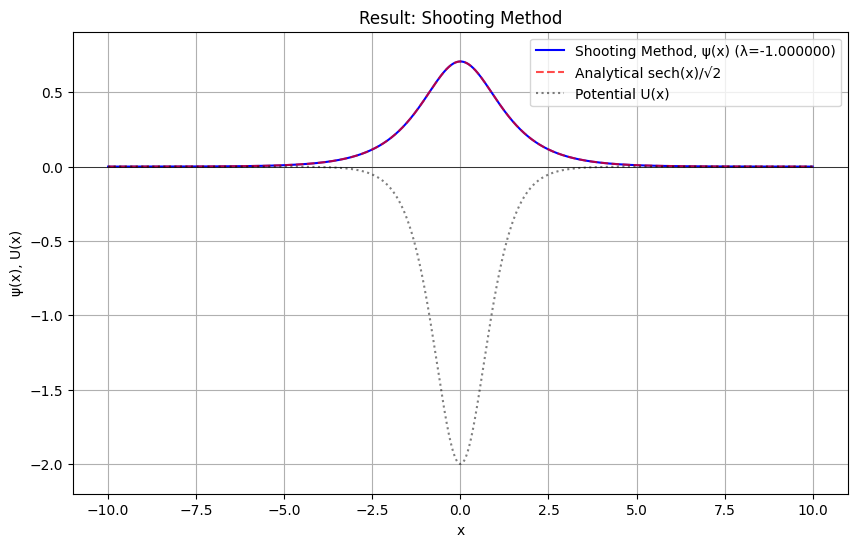

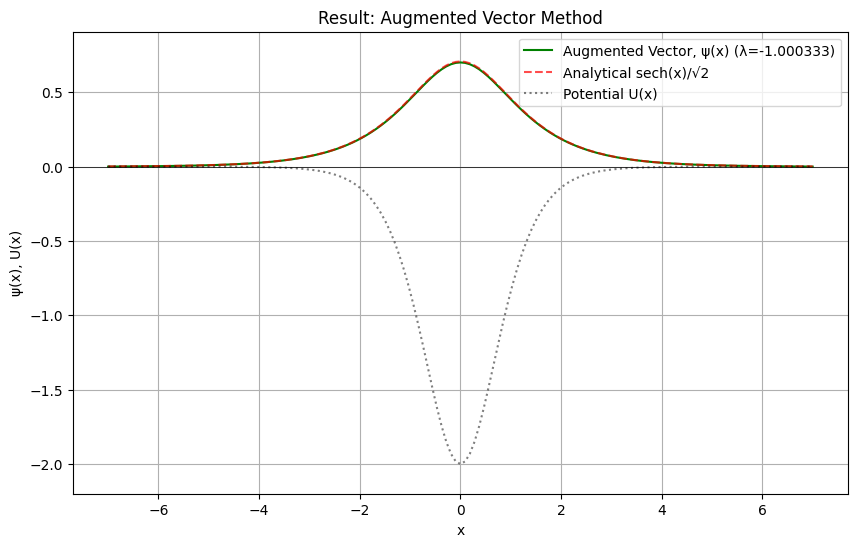


--- Comparison of Found Eigenvalues ---
Shooting Method:              λ = -0.99999998
Augmented Vector Method:      λ = -1.00033252
Analytical Value:             λ = -1.00000000


In [5]:
# ==============================================================================
# MAIN SCRIPT
# ==============================================================================
if __name__ == "__main__":
    # --- Solve by Shooting Method ---
    lambda_shoot, x_shoot, y_shoot = solve_by_shooting_method(
        X_max_shoot=10.0, 
        h_rk_shooting=0.002, # Finer step for shooting accuracy
        h_rk_plotting=0.01,
        bisection_tol_shoot=1e-8 # Tighter tolerance for bisection
    )

    # --- Solve by Augmented Vector Method ---
    lambda_aug, x_aug, y_aug = solve_by_augmented_vector_method(
        L_domain_aug=7.0, 
        N_points_aug=151, # More points for better discretization
        tol_newton_aug=2e-2,
        tol_seidel_aug=1e-7, 
        max_iter_seidel_aug=10000, # More iterations for Seidel
        omega_seidel_aug=1.1 # Try slight over-relaxation
    )

    # --- Plotting Results ---
    # Plot for Shooting Method
    if lambda_shoot is not None and x_shoot is not None and y_shoot is not None:
        plt.figure(figsize=(10, 6))
        plt.plot(x_shoot, y_shoot, 'b-', label=f'Shooting Method, ψ(x) (λ={lambda_shoot:.6f})')
        y_analytical_plot = np.cosh(x_shoot)**(-1) / np.sqrt(2.0) # sech(x)/sqrt(2) for λ=-1
        plt.plot(x_shoot, y_analytical_plot, 'r--', alpha=0.7, label='Analytical sech(x)/√2')
        U_plot_shoot = U(x_shoot)
        plt.plot(x_shoot, U_plot_shoot, 'k:', alpha=0.5, label='Potential U(x)')
        plt.title('Result: Shooting Method')
        plt.xlabel('x')
        plt.ylabel('ψ(x), U(x)')
        plt.legend()
        plt.grid(True)
        plt.axhline(0, color='black', lw=0.5)
        # Adjust y-limits to show both function and potential well
        min_y_plot = min(np.min(U_plot_shoot), np.min(y_shoot), np.min(y_analytical_plot))
        max_y_plot = max(np.max(y_analytical_plot), np.max(y_shoot))
        plt.ylim(min_y_plot - 0.2, max_y_plot + 0.2)
        plt.show()
    else:
        print("\nShooting method did not produce a solution for plotting.")

    # Plot for Augmented Vector Method
    if lambda_aug is not None and x_aug is not None and y_aug is not None:
        plt.figure(figsize=(10, 6))
        plt.plot(x_aug, y_aug, 'g-', label=f'Augmented Vector, ψ(x) (λ={lambda_aug:.6f})')
        y_analytical_plot_aug = np.cosh(x_aug)**(-1) / np.sqrt(2.0)
        plt.plot(x_aug, y_analytical_plot_aug, 'r--', alpha=0.7, label='Analytical sech(x)/√2')
        U_plot_aug = U(x_aug)
        plt.plot(x_aug, U_plot_aug, 'k:', alpha=0.5, label='Potential U(x)')
        plt.title('Result: Augmented Vector Method')
        plt.xlabel('x')
        plt.ylabel('ψ(x), U(x)')
        plt.legend()
        plt.grid(True)
        plt.axhline(0, color='black', lw=0.5)
        min_y_plot_aug = min(np.min(U_plot_aug), np.min(y_aug), np.min(y_analytical_plot_aug))
        max_y_plot_aug = max(np.max(y_analytical_plot_aug), np.max(y_aug))
        plt.ylim(min_y_plot_aug - 0.2, max_y_plot_aug + 0.2)
        plt.show()
    else:
        print("\nAugmented vector method did not produce a solution for plotting.")

    print("\n--- Comparison of Found Eigenvalues ---")
    if lambda_shoot is not None:
        print(f"Shooting Method:              λ = {lambda_shoot:.8f}")
    if lambda_aug is not None:
        print(f"Augmented Vector Method:      λ = {lambda_aug:.8f}")
    print(f"Analytical Value:             λ = -1.00000000")

## Выводы
В данной лабораторной работе мы решили `задачу Штурма-Лиувилля` при помощи двух методов: `пристрелки и дополненного вектора`. Оба метода пришли к результату, предсказанному теорией, хотя второй метод затратил на это больше времени (видимо матрица плохо обусловлена для метода Зейделя, поэтому сходимость медленная).